# Generating Fingerprints Using RDKit and LSTM

The colab doesn't have conda installed. Currently, RDkit only supports conda install. The following code installs the conda and RDKit.

In [ ]:
#!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
#!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
#!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
#!time conda install -c rdkit rdkit -y

import sys
sys.path.append('C:/Users/Zafarw/Anaconda3\Lib/site-packages/')

In [1]:
!pip install rdkit
!pip install ydata_profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 42.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.0/353.0 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 16.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.4/455.4 kB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 94.4 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=c843a6b72f40c3f11acc8eac57786fbb816de14919c838feeb8aff68ba14ad9a
  Stored in directory: /root/.cache/pip/whe

In [2]:
#!python --version
!pip install chembl_webresource_client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: attrs
    Found existing installation: attrs 23.1.0
    Uninstalling attrs-23.1.0:
      Successfully uninstalled attrs-23.1.0


In [3]:
import rdkit
rdkit.__version__

'2023.03.1'

In [4]:
import pandas as pd
from rdkit import Chem
import numpy as np # numpy is used to calculate the mean and standard deviation
import matplotlib.pyplot as plt # matplotlib is for drawing graphs
import matplotlib.colors as colors
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.preprocessing import scale # scale and center data
from sklearn.svm import SVC # this will make a support vector machine for classificaiton
from sklearn.model_selection import GridSearchCV # this will do cross validation
from sklearn.metrics import confusion_matrix # this creates a confusion matrix
#from sklearn.metrics import plot_confusion_matrix # draws  a confusion matrix
from sklearn.decomposition import PCA # to perform PCA to plot the data

from chembl_webresource_client.new_client import new_client
from chembl_webresource_client import *
from collections import Counter
from operator import itemgetter
from chembl_webresource_client.new_client import new_client
from rdkit.Chem import Descriptors, Lipinski
import seaborn as sns
from scipy.stats import skew
#import pandas_profiling
import ydata_profiling
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

## Data

In [5]:
#df_pubchem = pd.read_csv('PubChem_compound.csv')
#df_pubchem.head(1)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#file_path = "C:/Users/zafarw/Desktop/QSAR_Papers/Activity_cmp.tsv"
file_path = "/content/drive/My Drive/Activity_cmp.tsv"
Activity_cmp = pd.read_csv(file_path, sep="\t")
Activity_cmp.head(1)

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL1086484,NaN,None,525.53,2,6.79,GSK9027,O=S(=O)(Cc1ccccc1)Nc1ccc(-c2ccc3c(cnn3-c3ccc(F...,Inhibition,'=',...,SARS-CoV-2,Severe acute respiratory syndrome coronavirus 2,ORGANISM,CHEMBL4303101,52,SARS-CoV-2 Screening Data 2020-21,NaN,2020,CHEMBL3307519,NaN


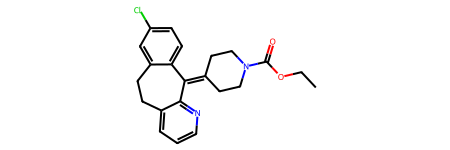

In [7]:
m =Chem.MolFromSmiles(Activity_cmp['Smiles'][1])
m

In [ ]:
Activity_cmp.shape

(37209, 45)

In [8]:
data_cmp = Activity_cmp[['Molecule ChEMBL ID','Smiles','Standard Value','AlogP']]
data_cmp.rename(columns={'Molecule ChEMBL ID': 'chembl_id', 'Standard Value': 'standard_value'}, inplace=True)
data_cmp.head(1)

<ipython-input-8-73a3dbce4914>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cmp.rename(columns={'Molecule ChEMBL ID': 'chembl_id', 'Standard Value': 'standard_value'}, inplace=True)


,chembl_id,Smiles,standard_value,AlogP
0,CHEMBL1086484,O=S(=O)(Cc1ccccc1)Nc1ccc(-c2ccc3c(cnn3-c3ccc(F...,100.2,6.79


In [9]:
bioactivity_threshold = []
for i in data_cmp.standard_value:
  if float(i) >= 1000:
    bioactivity_threshold.append("Inactive")
  elif float(i) <= 100:
    bioactivity_threshold.append("Active")
  else:
    bioactivity_threshold.append("Intermediate")

In [10]:
i=0
for num in data_cmp['standard_value']:
    if num<=100:
        i+=1
print(f"Number of the active class is {i}")

Number of the active class is 35636


In [11]:
bioactivity_class = pd.Series(bioactivity_threshold, name='class')
df3 = pd.concat([data_cmp, bioactivity_class], axis=1)
df4 = df3.drop(['standard_value'], axis=1)
df4 = df4[df4.chembl_id.notna()]
df4 = df4[df4.Smiles.notna()]
df4 = df4[df4.AlogP != 'None']

In [12]:
df4 = df4[df4['class'] != 'Intermediate']

In [60]:
df4['class'].value_counts()

Active      34902
Inactive     1000
Name: class, dtype: int64

In [13]:
from rdkit.Chem import PandasTools
PandasTools.AddMoleculeColumnToFrame(df4, smilesCol='Smiles')
df4.head(1)

,chembl_id,Smiles,AlogP,class,ROMol
2,CHEMBL178,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)...,1.03,Active,<rdkit.Chem.rdchem.Mol object at 0x7fac0cf5f8b0>


In [14]:
import rdkit
from rdkit.Chem import AllChem
FP = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024) for mol in df4.ROMol]
df_FP = pd.DataFrame(np.array(FP))

In [15]:
df_FP.index = df4.index
df4 = pd.concat([df4, df_FP], axis=1)

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score

In [33]:
from sklearn.metrics import confusion_matrix
import plotly.graph_objs as go
import plotly.offline as py
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

def plot_confusion_matrix(cm, classes, normalize=False,percent=True, title='Confusion matrix', cmap=plt.cm.Greens):
    blanks = ['' for i in range(cm.size)]
    if percent:
      group_percent = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    else:
      group_percent = blanks
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center", color="white"
                 if cm[i, j] > thresh else "black")



    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [18]:
from sklearn.preprocessing import LabelEncoder

# create a LabelEncoder object
label_encoder = LabelEncoder()

# fit and transform the categorical column in the dataframe
df4['class_label'] = label_encoder.fit_transform(df4['class'])

In [ ]:
#df4['class_label'] = df4['class_label'].fillna(0)

Text(0.5, 0.98, '0: 8092, 1: 537')

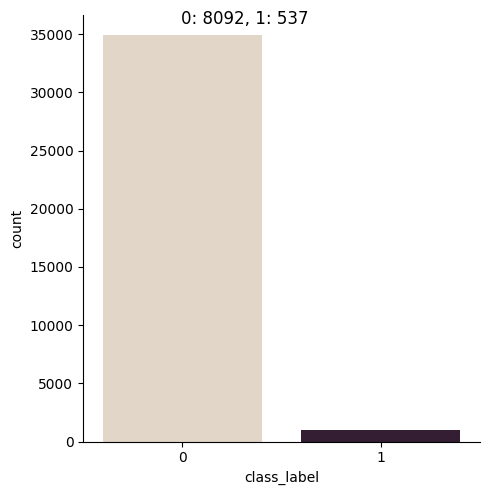

In [63]:
y = df4.class_label.values

#return the count for each unique value (0 and 1)
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

#plot the label counts
count1 = sns.catplot(x="class_label", kind="count", palette="ch:.25", data=df4)

#I added the count of class labels as the title here
count1.fig.suptitle('0: 8092, 1: 537')

## Machine Learning Algorithms

In [19]:
final_df = df4.drop(['class','class_label','Smiles','AlogP', 'ROMol'], axis=1)
final_df = final_df.drop(['chembl_id'], axis=1)
X = final_df.values
y = df4['class_label'].values


In [64]:
from imblearn.over_sampling import ADASYN
X, y = ADASYN().fit_resample(final_df, y)
morg_sample_count = sorted(Counter(y).items())

print("Morgan distribution:", morg_sample_count)

Morgan distribution: [(0, 34902), (1, 34753)]


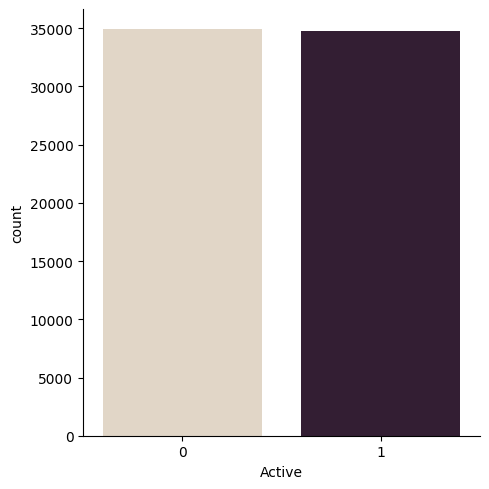

In [65]:
y_df = pd.DataFrame(y, columns=['Active'])
sns.catplot(x="Active", kind="count", palette="ch:.25", data=y_df);

In [70]:
#Splitting into Train And Test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Random Forest Classification

In [71]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import time
rf=RandomForestClassifier()
start_time=time.time()
rf.fit(X_train,y_train)
value_pred_rf = rf.predict(X_test)
scores_rf=cross_val_score(rf, X_test,y_test, cv=10)
print("Finished in ... ",time.time()-start_time)
print("Confusion Matrix obtained for random forest is \n",confusion_matrix(y_test,value_pred_rf))
print("Accuracy after applying random forest",(accuracy_score(y_test,value_pred_rf)))
print("Scores after applying 10 CV on random forest",np.average(scores_rf))
print("Precision for random forest ",precision_score(y_test,value_pred_rf, average = 'macro'))
print("Recall for random forest ",recall_score(y_test,value_pred_rf, average = 'macro'))

Finished in ...  99.4034173488617
Confusion Matrix obtained for random forest is 
 [[6557  360]
 [  40 6974]]
Accuracy after applying random forest 0.9712870576412318
Scores after applying 10 CV on random forest 0.9634630932897732
Precision for random forest  0.9724250955895158
Recall for random forest  0.97112571775015


In [73]:
conf_matrix = confusion_matrix(y_test,value_pred_rf)
plt.figure()

#plot_confusion_matrix(conf_matrix,

                     # classes=[0,1],

                      #title='Confusion matrix for Random Forest')

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Confusion matrix for Random Forest')

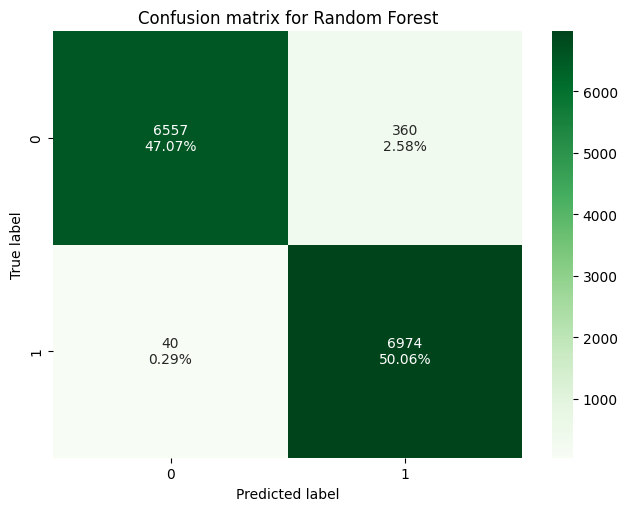

In [74]:
#group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Greens')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for Random Forest')

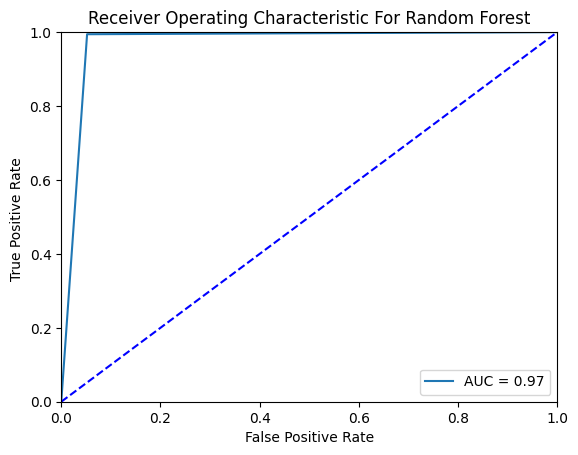

In [88]:
from sklearn import metrics
fpr_rf, tpr_rf, threshold_rf = metrics.roc_curve(y_test, value_pred_rf)
roc_auc_rf = metrics.auc(fpr_rf, tpr_rf)

plt.title('Receiver Operating Characteristic For Random Forest')
plt.plot(fpr_rf, tpr_rf, '', label = 'AUC = %0.2f' % roc_auc_rf)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle='--',color='blue')
plt.xlim([0, 1])   #values for x limit
plt.ylim([0, 1])#values for y limit
plt.ylabel('True Positive Rate ')
plt.xlabel('False Positive Rate')
plt.show()

## XGBoost

In [80]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score, recall_score
from xgboost import XGBClassifier
# fit model no training data
model_xgb = XGBClassifier()
start_time=time.time()
model_xgb.fit(X_train, y_train)
scores_xgb = cross_val_score(model_xgb, X_test,y_test, cv=10, error_score='raise')
y_pred = model_xgb.predict(X_test)
predictions = [round(value) for value in y_pred]
print("Finished in ... ",time.time()-start_time)
print("Confusion Matrix obtained for XG Boost is \n",confusion_matrix(y_test,y_pred))
print("Accuracy after applying XG Boost",(accuracy_score(y_test,y_pred)))
print("Scores after applying 10 CV on XG Boost",np.average(scores_xgb))
print("Precision for XG Boost ",precision_score(y_test,y_pred, average = 'micro'))
print("Recall for XG Boost ",recall_score(y_test, y_pred, average = 'micro'))

Finished in ...  131.92341232299805
Confusion Matrix obtained for XG Boost is 
 [[6462  455]
 [  61 6953]]
Accuracy after applying XG Boost 0.962960304357189
Scores after applying 10 CV on XG Boost 0.9537725005432985
Precision for XG Boost  0.962960304357189
Recall for XG Boost  0.962960304357189


In [81]:
conf_matrix_xgb = confusion_matrix(y_test,y_pred)
plt.figure()

#plot_confusion_matrix(conf_matrix_xgb,

                      #classes=[0,1],

                      #title='Confusion matrix for XG Boost of Morgan Finger Prints')

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Confusion matrix for XGBoost')

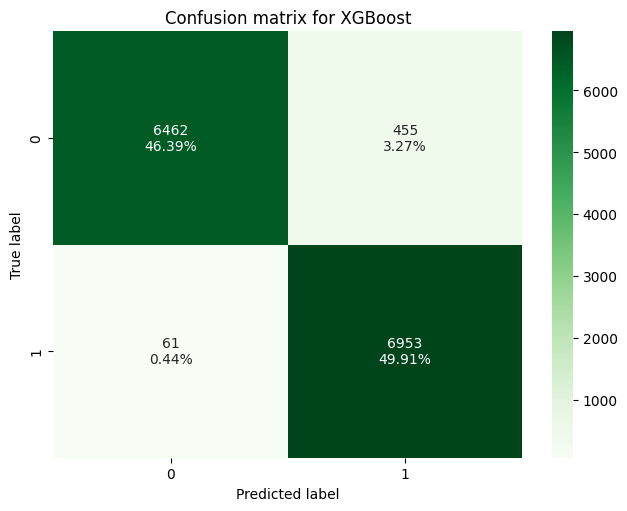

In [82]:
#group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix_xgb.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix_xgb.flatten()/np.sum(conf_matrix_xgb)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_matrix_xgb, annot=labels, fmt='', cmap='Greens')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for XGBoost')

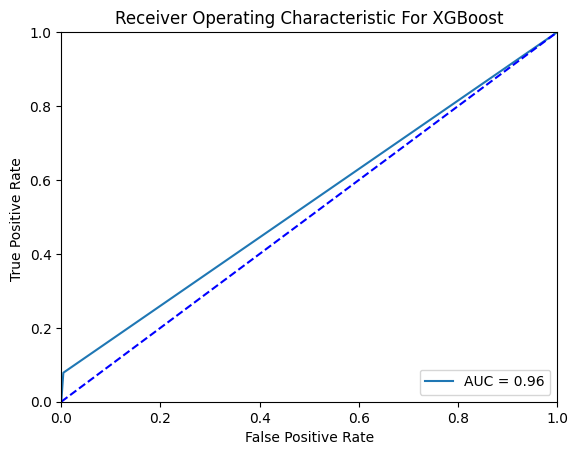

In [83]:
fpr_xg, tpr_xg, threshold_xg = metrics.roc_curve(y_test, y_pred)
roc_auc_xg = metrics.auc(fpr_xg, tpr_xg)

plt.title('Receiver Operating Characteristic For XGBoost')
plt.plot(fpr_rf, tpr_rf, '', label = 'AUC = %0.2f' % roc_auc_xg)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle='--',color='blue')
plt.xlim([0, 1])   #values for x limit
plt.ylim([0, 1])#values for y limit
plt.ylabel('True Positive Rate ')
plt.xlabel('False Positive Rate')
plt.show()

## Support Vector Machine

In [84]:
from sklearn import svm
from sklearn.svm import SVC
load_svm=svm.SVC(C=1.0, kernel='rbf', degree=3)
start_time=time.time()
load_svm.fit(X_train,y_train)
value_pred_svm = load_svm.predict(X_test)
scores_svm=cross_val_score(load_svm, X_test,y_test, cv=10)
print("Finished in ... ",time.time()-start_time)
print("Confusion Matrix obtained for Support Vector Machine Classifier is \n",confusion_matrix(y_test,value_pred_svm))
print("Accuracy after applying Support Vector Machine is",(accuracy_score(y_test,value_pred_svm)))
print("Scores after applying 10 CV on Support Vector Machine",np.average(scores_svm))
print("Precision for Support Vector Machine ",precision_score(y_test,value_pred_svm, average = 'micro'))
print("Recall for Support Vector Machine ",recall_score(y_test,value_pred_svm, average = 'micro'))

Finished in ...  1067.9578471183777
Confusion Matrix obtained for Support Vector Machine Classifier is 
 [[6536  381]
 [  59 6955]]
Accuracy after applying Support Vector Machine is 0.968415763405355
Scores after applying 10 CV on Support Vector Machine 0.9572898824930144
Precision for Support Vector Machine  0.968415763405355
Recall for Support Vector Machine  0.968415763405355


In [85]:
conf_matrix_svm = confusion_matrix(y_test,value_pred_svm)
plt.figure()

#plot_confusion_matrix(conf_matrix_svm,

                      #classes=[0,1],

                      #title='Confusion matrix for Support Vector Machine of Morgan FingerPrints')

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Confusion matrix for SVM')

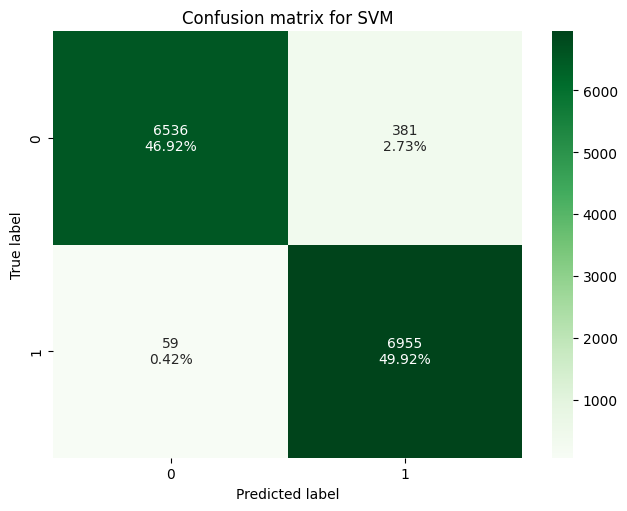

In [86]:
#group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix_svm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix_svm.flatten()/np.sum(conf_matrix_svm)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_matrix_svm, annot=labels, fmt='', cmap='Greens')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for SVM')

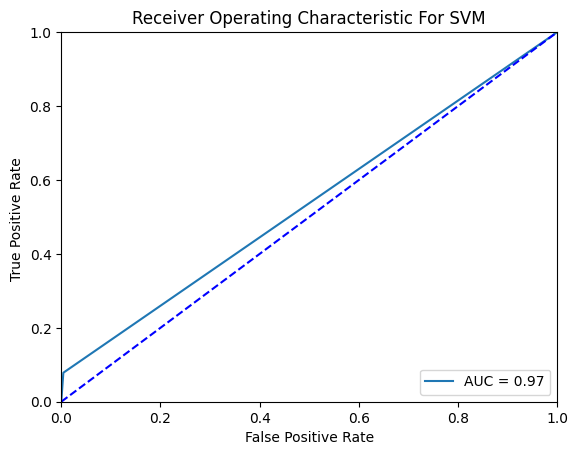

In [87]:
fpr_svm, tpr_svm, threshold_svm = metrics.roc_curve(y_test, value_pred_svm)
roc_auc_svm = metrics.auc(fpr_svm, tpr_svm)

plt.title('Receiver Operating Characteristic For SVM')
plt.plot(fpr_rf, tpr_rf, '', label = 'AUC = %0.2f' % roc_auc_svm)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle='--',color='blue')
plt.xlim([0, 1])   #values for x limit
plt.ylim([0, 1])#values for y limit
plt.ylabel('True Positive Rate ')
plt.xlabel('False Positive Rate')
plt.show()

## LSTM modleing using Smiles

In [43]:
data = pd.DataFrame(df4['Smiles'])
smiles_train, smiles_test = train_test_split(data["Smiles"], random_state=42)

In [44]:
charset = set("".join(list(data.Smiles))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
embed = max([len(smile) for smile in data.Smiles]) + 5
print (str(charset))
print(len(charset), embed)

{'F', 'C', 'O', 'N', '4', ']', 'I', '=', 'r', '@', 'K', '5', 'g', 'E', 'L', '!', 'S', 'n', '6', '9', 'a', 'H', '/', 's', 'i', 'A', '(', '8', 'o', 'l', 'Z', '3', '\\', '+', ')', 'c', '[', '#', '-', 'M', '7', 'B', 'P', '2', '1', '.'}
46 318


Br.Cc1ccc(Sc2ccccc2N2CCNCC2)c(C)c1


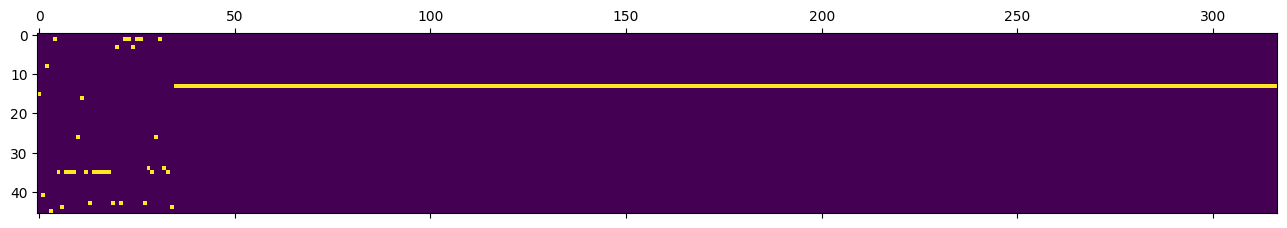

In [45]:
def vectorize(smiles):
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,0:-1,:], one_hot[:,1:,:]
X_train, Y_train = vectorize(smiles_train.values)
X_test,Y_test = vectorize(smiles_test.values)
print(smiles_train.iloc[0])
plt.matshow(X_train[0].T)
#print X_train.shape

In [46]:
#Import Keras objects
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Concatenate
from keras import regularizers
input_shape = X_train.shape[1:]
output_dim = Y_train.shape[-1]
latent_dim = 64
lstm_dim = 64

In [47]:
unroll = False
encoder_inputs = Input(shape=input_shape)
encoder = LSTM(lstm_dim, return_state=True,
                unroll=unroll)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
states = Concatenate(axis=-1)([state_h, state_c])
neck = Dense(latent_dim, activation="sigmoid")
neck_outputs = neck(states)

In [48]:
decode_h = Dense(lstm_dim, activation="sigmoid")
decode_c = Dense(lstm_dim, activation="sigmoid")
state_h_decoded =  decode_h(neck_outputs)
state_c_decoded =  decode_c(neck_outputs)
encoder_states = [state_h_decoded, state_c_decoded]
decoder_inputs = Input(shape=input_shape)
decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll
                   )
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(output_dim, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
#Define the model, that inputs the training vector for two places, and predicts one character ahead of the input
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 317, 46)]    0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 64),         28416       ['input_1[0][0]']                
                                 (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                                  
 concatenate (Concatenate)      (None, 128)          0           ['lstm[0][1]',                   
                                                                  'lstm[0][2]']               

In [49]:
from keras.callbacks import History, ReduceLROnPlateau
h = History()
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, epsilon=1e-5)


In [50]:
from keras.optimizers import RMSprop, Adam
opt=Adam(lr=0.005) #Default 0.001
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
model.fit([X_train,X_train],Y_train,
                    epochs=200,
                    batch_size=256,
                    shuffle=True,
                    callbacks=[h, rlr],
                    validation_data=[[X_test,X_test],Y_test ])

Epoch 1/200
106/106 [==============================] - 12s 43ms/step - loss: 0.7045 - accuracy: 0.8577 - val_loss: 0.4191 - val_accuracy: 0.8829 - lr: 0.0050
Epoch 2/200
106/106 [==============================] - 3s 30ms/step - loss: 0.3662 - accuracy: 0.8978 - val_loss: 0.3148 - val_accuracy: 0.9124 - lr: 0.0050
Epoch 3/200
106/106 [==============================] - 3s 30ms/step - loss: 0.2827 - accuracy: 0.9167 - val_loss: 0.2559 - val_accuracy: 0.9218 - lr: 0.0050
Epoch 4/200
106/106 [==============================] - 3s 30ms/step - loss: 0.2406 - accuracy: 0.9250 - val_loss: 0.2263 - val_accuracy: 0.9288 - lr: 0.0050
Epoch 5/200
106/106 [==============================] - 3s 29ms/step - loss: 0.2178 - accuracy: 0.9308 - val_loss: 0.2085 - val_accuracy: 0.9336 - lr: 0.0050
Epoch 6/200
106/106 [==============================] - 3s 31ms/step - loss: 0.2037 - accuracy: 0.9346 - val_loss: 0.1978 - val_accuracy: 0.9365 - lr: 0.0050
Epoch 7/200
106/106 [==============================] - 3s

In [52]:
import pickle
pickle.dump(h.history, open("Blog_history.pickle","wb"))

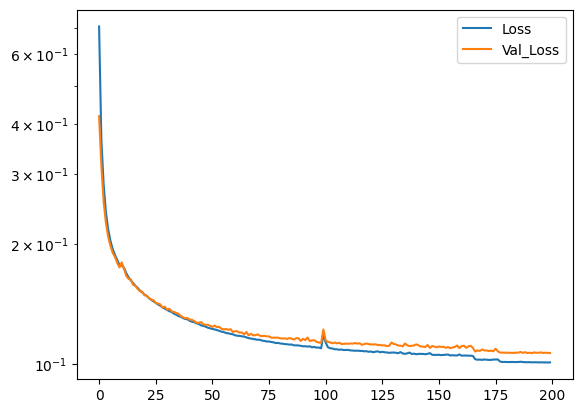

In [53]:
plt.plot(h.history["loss"], label="Loss")
plt.plot(h.history["val_loss"], label="Val_Loss")
plt.yscale("log")
plt.legend()

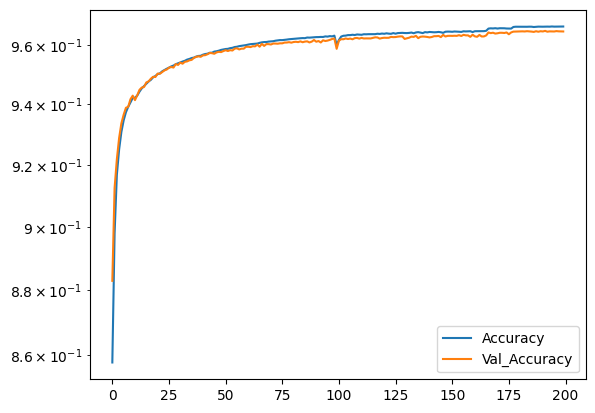

In [54]:
plt.plot(h.history["accuracy"], label="Accuracy")
plt.plot(h.history["val_accuracy"], label="Val_Accuracy")
plt.yscale("log")
plt.legend()

In [ ]:
h.history["accuracy"]

In [ ]:
for i in range(10):
    v = model.predict([X_test[i:i+1], X_test[i:i+1]]) #Can't be done as output not necessarely 1
    idxs = np.argmax(v, axis=2)
    pred=  "".join([int_to_char[h] for h in idxs[0]])[:-1]
    idxs2 = np.argmax(X_test[i:i+1], axis=2)
    true =  "".join([int_to_char[k] for k in idxs2[0]])[1:]
    if true != pred:
        print(true, pred)

1/1 [==============================] - 1s 694ms/step
COc1cc2nc(N3CCCN(C)CC3)nc(NC3CCN(Cc4ccccc4)CC3)c2cc1OCEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE CCc1ccccccN3CCN((CCCC3)cc(N3(CCC(C)4ccc(c4)CC3)c2cc1OCEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
1/1 [==============================] - 0s 29ms/step
CC1CCc2c(cc(Br)c(F)c2Br)N1C=OEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE

In [ ]:
smiles_to_latent_model = Model(encoder_inputs, neck_outputs)

In [ ]:
smiles_to_latent_model.save("Blog_simple_smi2lat.h5")

In [ ]:
latent_input = Input(shape=(latent_dim,))
#reuse_layers
state_h_decoded_2 =  decode_h(latent_input)
state_c_decoded_2 =  decode_c(latent_input)
latent_to_states_model = Model(latent_input, [state_h_decoded_2, state_c_decoded_2])
latent_to_states_model.save("Blog_simple_lat2state.h5")


In [ ]:
#Last one is special, we need to change it to stateful, and change the input shape
inf_decoder_inputs = Input(batch_shape=(1, 1, input_shape[1]))
inf_decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll,
                    stateful=True
                   )
inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs)
inf_decoder_dense = Dense(output_dim, activation='softmax')
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)
sample_model = Model(inf_decoder_inputs, inf_decoder_outputs)


In [ ]:
#Transfer Weights
for i in range(1,3):
    sample_model.layers[i].set_weights(model.layers[i+6].get_weights())
sample_model.save("Blog_simple_samplemodel.h5")

In [ ]:
x_latent = smiles_to_latent_model.predict(X_test)

281/281 [==============================] - 1s 5ms/step


1/1 [==============================] - 0s 22ms/step
[8972 8174 3206 4185 1916 6240 6956 7421 1133 7400]
21058              Clc1ccc(Cn2c(CN3CCCC3)nc3ccccc32)cc1
36807              C=Cc1cc(O)cc2nc(-c3ccc(O)c(F)c3)oc12
4499       O=C(Nc1cc(Cl)cc(Cl)c1O)c1c(O)c(Cl)cc(Cl)c1Cl
22516           OCCCNc1cc(-c2ccnc(Nc3cccc(Cl)c3)n2)ccn1
3718                Oc1c(Cl)cc(Cl)cc1Sc1cc(Cl)cc(Cl)c1O
18798    OC(CN1CCN(c2cccc(Cl)c2)CC1)C(c1ccccc1)c1ccccc1
29967             CCn1cnc2c(Nc3cc(F)cc(F)c3)nc(C#N)nc21
34557                CCN(c1ccccc1)c1c/c(=N/C)n(C)c(C)n1
Name: Smiles, dtype: object


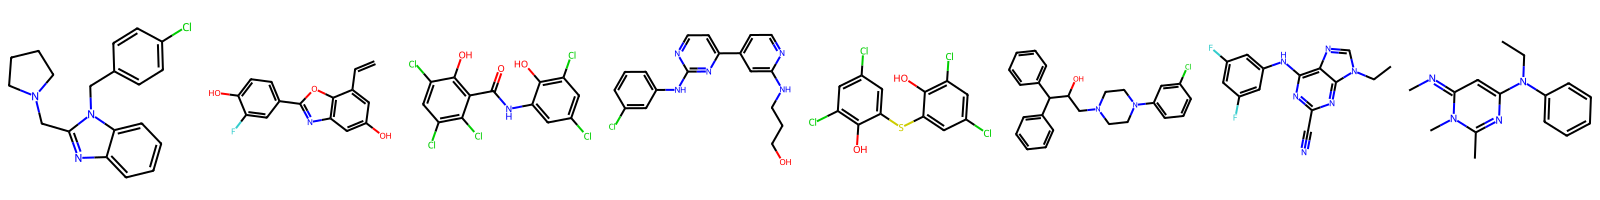

In [ ]:
from rdkit.Chem import Draw, Descriptors
molno = 5
latent_mol = smiles_to_latent_model.predict(X_test[molno:molno+1])
sorti = np.argsort(np.sum(np.abs(x_latent - latent_mol), axis=1))
print(sorti[0:10])
print(smiles_test.iloc[sorti[0:8]])
Draw.MolsToImage(smiles_test.iloc[sorti[0:8]].apply(Chem.MolFromSmiles))

In [ ]:
logp = smiles_test.apply(Chem.MolFromSmiles).apply(Descriptors.MolLogP)

[0.9881991  0.01072476] 0.9989239


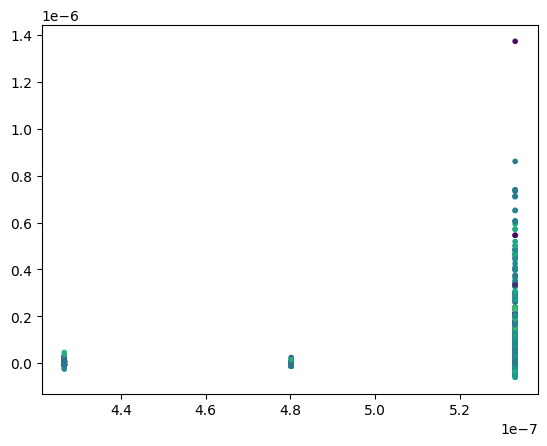

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
red = pca.fit_transform(x_latent)
plt.figure()
plt.scatter(red[:,0], red[:,1],marker='.', c= logp)
print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))

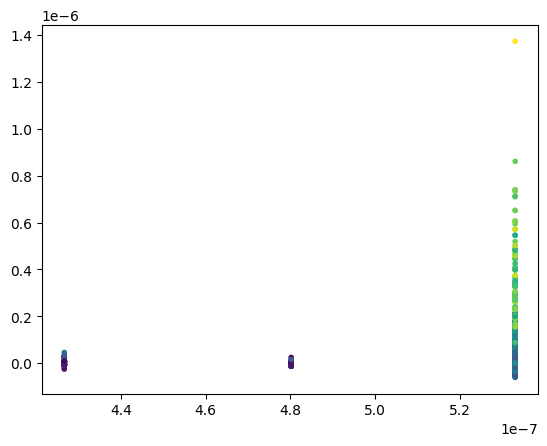

In [ ]:
molwt = smiles_test.apply(Chem.MolFromSmiles).apply(Descriptors.MolMR)
plt.figure()
plt.scatter(red[:,0], red[:,1],marker='.', c= molwt)

In [ ]:
#Model LogP?
x_train_latent = smiles_to_latent_model.predict(X_train)
logp_train = smiles_train.apply(Chem.MolFromSmiles).apply(Descriptors.MolLogP)

842/842 [==============================] - 4s 5ms/step


In [ ]:
from keras.models import Sequential
logp_model = Sequential()
logp_model.add(Dense(128, input_shape=(latent_dim,), activation="relu"))
logp_model.add(Dense(128, activation="relu"))
logp_model.add(Dense(1))
logp_model.compile(optimizer="adam", loss="mse")

In [ ]:
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, epsilon=1e-5)
logp_model.fit(x_train_latent, logp_train, batch_size=128, epochs=400, callbacks = [rlr])


Epoch 1/400
196/211 [==========================>...] - ETA: 0s - loss: 5.9787

211/211 [==============================] - 2s 2ms/step - loss: 5.9765 - lr: 0.0010
Epoch 2/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8245

211/211 [==============================] - 0s 2ms/step - loss: 5.8328 - lr: 0.0010
Epoch 3/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8345

211/211 [==============================] - 0s 2ms/step - loss: 5.8325 - lr: 0.0010
Epoch 4/400
195/211 [==========================>...] - ETA: 0s - loss: 5.8710

211/211 [==============================] - 1s 2ms/step - loss: 5.8383 - lr: 0.0010
Epoch 5/400
200/211 [===========================>..] - ETA: 0s - loss: 5.8396

211/211 [==============================] - 0s 2ms/step - loss: 5.8382 - lr: 0.0010
Epoch 6/400
195/211 [==========================>...] - ETA: 0s - loss: 5.8640

211/211 [==============================] - 1s 2ms/step - loss: 5.8325 - lr: 0.0010
Epoch 7/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8385

211/211 [==============================] - 0s 2ms/step - loss: 5.8291 - lr: 0.0010
Epoch 8/400
200/211 [===========================>..] - ETA: 0s - loss: 5.8402

211/211 [==============================] - 0s 2ms/step - loss: 5.8373 - lr: 0.0010
Epoch 9/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8518

211/211 [==============================] - 0s 2ms/step - loss: 5.8377 - lr: 0.0010
Epoch 10/400
197/211 [===========================>..] - ETA: 0s - loss: 5.7993

211/211 [==============================] - 0s 2ms/step - loss: 5.8373 - lr: 0.0010
Epoch 11/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8241

211/211 [==============================] - 0s 2ms/step - loss: 5.8211 - lr: 0.0010
Epoch 12/400
196/211 [==========================>...] - ETA: 0s - loss: 5.8237

211/211 [==============================] - 0s 2ms/step - loss: 5.8255 - lr: 0.0010
Epoch 13/400
200/211 [===========================>..] - ETA: 0s - loss: 5.8353

211/211 [==============================] - 0s 2ms/step - loss: 5.8344 - lr: 0.0010
Epoch 14/400
197/211 [===========================>..] - ETA: 0s - loss: 5.7855

211/211 [==============================] - 1s 2ms/step - loss: 5.8197 - lr: 0.0010
Epoch 15/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8017

211/211 [==============================] - 0s 2ms/step - loss: 5.8296 - lr: 0.0010
Epoch 16/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8474

211/211 [==============================] - 0s 2ms/step - loss: 5.8314 - lr: 0.0010
Epoch 17/400
196/211 [==========================>...] - ETA: 0s - loss: 5.8679

211/211 [==============================] - 1s 2ms/step - loss: 5.8234 - lr: 0.0010
Epoch 18/400
193/211 [==========================>...] - ETA: 0s - loss: 5.8211

211/211 [==============================] - 1s 2ms/step - loss: 5.8263 - lr: 0.0010
Epoch 19/400
194/211 [==========================>...] - ETA: 0s - loss: 5.8259

211/211 [==============================] - 1s 2ms/step - loss: 5.8253 - lr: 0.0010
Epoch 20/400
194/211 [==========================>...] - ETA: 0s - loss: 5.8391

211/211 [==============================] - 1s 2ms/step - loss: 5.8327 - lr: 0.0010
Epoch 21/400
194/211 [==========================>...] - ETA: 0s - loss: 5.8292

211/211 [==============================] - 1s 2ms/step - loss: 5.8293 - lr: 0.0010
Epoch 22/400
211/211 [==============================] - ETA: 0s - loss: 5.8208

211/211 [==============================] - 1s 2ms/step - loss: 5.8208 - lr: 0.0010
Epoch 23/400
197/211 [===========================>..] - ETA: 0s - loss: 5.7975

211/211 [==============================] - 1s 2ms/step - loss: 5.8242 - lr: 0.0010
Epoch 24/400
198/211 [===========================>..] - ETA: 0s - loss: 5.7888

211/211 [==============================] - 0s 2ms/step - loss: 5.8210 - lr: 0.0010
Epoch 25/400
200/211 [===========================>..] - ETA: 0s - loss: 5.7989

211/211 [==============================] - 0s 2ms/step - loss: 5.8210 - lr: 0.0010
Epoch 26/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8244

211/211 [==============================] - 0s 2ms/step - loss: 5.8193 - lr: 0.0010
Epoch 27/400
202/211 [===========================>..] - ETA: 0s - loss: 5.8010

211/211 [==============================] - 0s 2ms/step - loss: 5.8254 - lr: 0.0010
Epoch 28/400
198/211 [===========================>..] - ETA: 0s - loss: 5.7937

211/211 [==============================] - 0s 2ms/step - loss: 5.8247 - lr: 0.0010
Epoch 29/400
202/211 [===========================>..] - ETA: 0s - loss: 5.8046

211/211 [==============================] - 0s 2ms/step - loss: 5.8244 - lr: 0.0010
Epoch 30/400
196/211 [==========================>...] - ETA: 0s - loss: 5.8593

211/211 [==============================] - 0s 2ms/step - loss: 5.8243 - lr: 0.0010
Epoch 31/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8321

211/211 [==============================] - 0s 2ms/step - loss: 5.8224 - lr: 0.0010
Epoch 32/400
196/211 [==========================>...] - ETA: 0s - loss: 5.8430

211/211 [==============================] - 0s 2ms/step - loss: 5.8317 - lr: 0.0010
Epoch 33/400
200/211 [===========================>..] - ETA: 0s - loss: 5.8317

211/211 [==============================] - 0s 2ms/step - loss: 5.8272 - lr: 0.0010
Epoch 34/400
197/211 [===========================>..] - ETA: 0s - loss: 5.7886

211/211 [==============================] - 0s 2ms/step - loss: 5.8251 - lr: 0.0010
Epoch 35/400
200/211 [===========================>..] - ETA: 0s - loss: 5.8306

211/211 [==============================] - 0s 2ms/step - loss: 5.8294 - lr: 0.0010
Epoch 36/400
199/211 [===========================>..] - ETA: 0s - loss: 5.7970

211/211 [==============================] - 0s 2ms/step - loss: 5.8233 - lr: 0.0010
Epoch 37/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8163

211/211 [==============================] - 0s 2ms/step - loss: 5.8247 - lr: 0.0010
Epoch 38/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8447

211/211 [==============================] - 0s 2ms/step - loss: 5.8261 - lr: 0.0010
Epoch 39/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8530

211/211 [==============================] - 0s 2ms/step - loss: 5.8272 - lr: 0.0010
Epoch 40/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8389

211/211 [==============================] - 0s 2ms/step - loss: 5.8271 - lr: 0.0010
Epoch 41/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8223

211/211 [==============================] - 0s 2ms/step - loss: 5.8237 - lr: 0.0010
Epoch 42/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8515

211/211 [==============================] - 0s 2ms/step - loss: 5.8230 - lr: 0.0010
Epoch 43/400
195/211 [==========================>...] - ETA: 0s - loss: 5.8493

211/211 [==============================] - 1s 2ms/step - loss: 5.8222 - lr: 0.0010
Epoch 44/400
206/211 [============================>.] - ETA: 0s - loss: 5.8146

211/211 [==============================] - 1s 3ms/step - loss: 5.8232 - lr: 0.0010
Epoch 45/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8012

211/211 [==============================] - 0s 2ms/step - loss: 5.8189 - lr: 0.0010
Epoch 46/400
196/211 [==========================>...] - ETA: 0s - loss: 5.8571

211/211 [==============================] - 0s 2ms/step - loss: 5.8217 - lr: 0.0010
Epoch 47/400
196/211 [==========================>...] - ETA: 0s - loss: 5.8314

211/211 [==============================] - 1s 2ms/step - loss: 5.8200 - lr: 0.0010
Epoch 48/400
211/211 [==============================] - ETA: 0s - loss: 5.8224

211/211 [==============================] - 1s 2ms/step - loss: 5.8224 - lr: 0.0010
Epoch 49/400
192/211 [==========================>...] - ETA: 0s - loss: 5.8426

211/211 [==============================] - 1s 2ms/step - loss: 5.8298 - lr: 0.0010
Epoch 50/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8489

211/211 [==============================] - 0s 2ms/step - loss: 5.8205 - lr: 0.0010
Epoch 51/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8225

211/211 [==============================] - 0s 2ms/step - loss: 5.8233 - lr: 0.0010
Epoch 52/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8503

211/211 [==============================] - 0s 2ms/step - loss: 5.8228 - lr: 0.0010
Epoch 53/400
201/211 [===========================>..] - ETA: 0s - loss: 5.8574

211/211 [==============================] - 0s 2ms/step - loss: 5.8194 - lr: 0.0010
Epoch 54/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8476

211/211 [==============================] - 0s 2ms/step - loss: 5.8278 - lr: 0.0010
Epoch 55/400
202/211 [===========================>..] - ETA: 0s - loss: 5.8494

211/211 [==============================] - 0s 2ms/step - loss: 5.8240 - lr: 0.0010
Epoch 56/400
198/211 [===========================>..] - ETA: 0s - loss: 5.7930

211/211 [==============================] - 0s 2ms/step - loss: 5.8211 - lr: 0.0010
Epoch 57/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8217

211/211 [==============================] - 0s 2ms/step - loss: 5.8237 - lr: 0.0010
Epoch 58/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8625

211/211 [==============================] - 0s 2ms/step - loss: 5.8306 - lr: 0.0010
Epoch 59/400
192/211 [==========================>...] - ETA: 0s - loss: 5.8148

211/211 [==============================] - 1s 2ms/step - loss: 5.8197 - lr: 0.0010
Epoch 60/400
203/211 [===========================>..] - ETA: 0s - loss: 5.8092

211/211 [==============================] - 1s 3ms/step - loss: 5.8255 - lr: 0.0010
Epoch 61/400
211/211 [==============================] - ETA: 0s - loss: 5.8238

211/211 [==============================] - 1s 2ms/step - loss: 5.8238 - lr: 0.0010
Epoch 62/400
210/211 [============================>.] - ETA: 0s - loss: 5.8256

211/211 [==============================] - 1s 2ms/step - loss: 5.8239 - lr: 0.0010
Epoch 63/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8192

211/211 [==============================] - 0s 2ms/step - loss: 5.8220 - lr: 0.0010
Epoch 64/400
196/211 [==========================>...] - ETA: 0s - loss: 5.8184

211/211 [==============================] - 1s 2ms/step - loss: 5.8295 - lr: 0.0010
Epoch 65/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8377

211/211 [==============================] - 0s 2ms/step - loss: 5.8227 - lr: 0.0010
Epoch 66/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8340

211/211 [==============================] - 0s 2ms/step - loss: 5.8266 - lr: 0.0010
Epoch 67/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8277

211/211 [==============================] - 0s 2ms/step - loss: 5.8285 - lr: 0.0010
Epoch 68/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8059

211/211 [==============================] - 0s 2ms/step - loss: 5.8226 - lr: 0.0010
Epoch 69/400
194/211 [==========================>...] - ETA: 0s - loss: 5.8254

211/211 [==============================] - 1s 2ms/step - loss: 5.8243 - lr: 0.0010
Epoch 70/400
191/211 [==========================>...] - ETA: 0s - loss: 5.8351

211/211 [==============================] - 1s 2ms/step - loss: 5.8192 - lr: 0.0010
Epoch 71/400
193/211 [==========================>...] - ETA: 0s - loss: 5.8158

211/211 [==============================] - 1s 2ms/step - loss: 5.8200 - lr: 0.0010
Epoch 72/400
192/211 [==========================>...] - ETA: 0s - loss: 5.7811

211/211 [==============================] - 1s 2ms/step - loss: 5.8194 - lr: 0.0010
Epoch 73/400
211/211 [==============================] - ETA: 0s - loss: 5.8188

211/211 [==============================] - 1s 2ms/step - loss: 5.8188 - lr: 0.0010
Epoch 74/400
211/211 [==============================] - ETA: 0s - loss: 5.8211

211/211 [==============================] - 1s 2ms/step - loss: 5.8211 - lr: 0.0010
Epoch 75/400
194/211 [==========================>...] - ETA: 0s - loss: 5.8428

211/211 [==============================] - 1s 2ms/step - loss: 5.8220 - lr: 0.0010
Epoch 76/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8252

211/211 [==============================] - 0s 2ms/step - loss: 5.8216 - lr: 0.0010
Epoch 77/400
197/211 [===========================>..] - ETA: 0s - loss: 5.7758

211/211 [==============================] - 0s 2ms/step - loss: 5.8211 - lr: 0.0010
Epoch 78/400
200/211 [===========================>..] - ETA: 0s - loss: 5.8057

211/211 [==============================] - 0s 2ms/step - loss: 5.8203 - lr: 0.0010
Epoch 79/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8529

211/211 [==============================] - 0s 2ms/step - loss: 5.8181 - lr: 0.0010
Epoch 80/400
200/211 [===========================>..] - ETA: 0s - loss: 5.8641

211/211 [==============================] - 0s 2ms/step - loss: 5.8210 - lr: 0.0010
Epoch 81/400
198/211 [===========================>..] - ETA: 0s - loss: 5.7763

211/211 [==============================] - 0s 2ms/step - loss: 5.8214 - lr: 0.0010
Epoch 82/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8206

211/211 [==============================] - 0s 2ms/step - loss: 5.8242 - lr: 0.0010
Epoch 83/400
200/211 [===========================>..] - ETA: 0s - loss: 5.8097

211/211 [==============================] - 0s 2ms/step - loss: 5.8180 - lr: 0.0010
Epoch 84/400
202/211 [===========================>..] - ETA: 0s - loss: 5.8307

211/211 [==============================] - 0s 2ms/step - loss: 5.8210 - lr: 0.0010
Epoch 85/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8187

211/211 [==============================] - 1s 2ms/step - loss: 5.8220 - lr: 0.0010
Epoch 86/400
191/211 [==========================>...] - ETA: 0s - loss: 5.8430

211/211 [==============================] - 1s 2ms/step - loss: 5.8262 - lr: 0.0010
Epoch 87/400
205/211 [============================>.] - ETA: 0s - loss: 5.7942

211/211 [==============================] - 1s 3ms/step - loss: 5.8216 - lr: 0.0010
Epoch 88/400
197/211 [===========================>..] - ETA: 0s - loss: 5.7840

211/211 [==============================] - 1s 2ms/step - loss: 5.8185 - lr: 0.0010
Epoch 89/400
195/211 [==========================>...] - ETA: 0s - loss: 5.7862

211/211 [==============================] - 1s 2ms/step - loss: 5.8239 - lr: 0.0010
Epoch 90/400
204/211 [============================>.] - ETA: 0s - loss: 5.8130

211/211 [==============================] - 1s 3ms/step - loss: 5.8222 - lr: 0.0010
Epoch 91/400
204/211 [============================>.] - ETA: 0s - loss: 5.8073

211/211 [==============================] - 1s 3ms/step - loss: 5.8193 - lr: 0.0010
Epoch 92/400
195/211 [==========================>...] - ETA: 0s - loss: 5.8465

211/211 [==============================] - 1s 3ms/step - loss: 5.8380 - lr: 0.0010
Epoch 93/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8303

211/211 [==============================] - 1s 3ms/step - loss: 5.8217 - lr: 0.0010
Epoch 94/400
209/211 [============================>.] - ETA: 0s - loss: 5.8207

211/211 [==============================] - 1s 2ms/step - loss: 5.8183 - lr: 0.0010
Epoch 95/400
211/211 [==============================] - ETA: 0s - loss: 5.8217

211/211 [==============================] - 1s 2ms/step - loss: 5.8217 - lr: 0.0010
Epoch 96/400
202/211 [===========================>..] - ETA: 0s - loss: 5.7890

211/211 [==============================] - 1s 3ms/step - loss: 5.8210 - lr: 0.0010
Epoch 97/400
193/211 [==========================>...] - ETA: 0s - loss: 5.8345

211/211 [==============================] - 1s 3ms/step - loss: 5.8222 - lr: 0.0010
Epoch 98/400
192/211 [==========================>...] - ETA: 0s - loss: 5.7695

211/211 [==============================] - 1s 2ms/step - loss: 5.8220 - lr: 0.0010
Epoch 99/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8079

211/211 [==============================] - 1s 3ms/step - loss: 5.8251 - lr: 0.0010
Epoch 100/400
200/211 [===========================>..] - ETA: 0s - loss: 5.8215

211/211 [==============================] - 1s 3ms/step - loss: 5.8196 - lr: 0.0010
Epoch 101/400
210/211 [============================>.] - ETA: 0s - loss: 5.8161

211/211 [==============================] - 1s 3ms/step - loss: 5.8215 - lr: 0.0010
Epoch 102/400
205/211 [============================>.] - ETA: 0s - loss: 5.8154

211/211 [==============================] - 1s 3ms/step - loss: 5.8181 - lr: 0.0010
Epoch 103/400
200/211 [===========================>..] - ETA: 0s - loss: 5.8361

211/211 [==============================] - 0s 2ms/step - loss: 5.8316 - lr: 0.0010
Epoch 104/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8437

211/211 [==============================] - 0s 2ms/step - loss: 5.8193 - lr: 0.0010
Epoch 105/400
200/211 [===========================>..] - ETA: 0s - loss: 5.8174

211/211 [==============================] - 0s 2ms/step - loss: 5.8208 - lr: 0.0010
Epoch 106/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8166

211/211 [==============================] - 0s 2ms/step - loss: 5.8218 - lr: 0.0010
Epoch 107/400
192/211 [==========================>...] - ETA: 0s - loss: 5.8401

211/211 [==============================] - 1s 2ms/step - loss: 5.8196 - lr: 0.0010
Epoch 108/400
209/211 [============================>.] - ETA: 0s - loss: 5.8153

211/211 [==============================] - 1s 2ms/step - loss: 5.8182 - lr: 0.0010
Epoch 109/400
191/211 [==========================>...] - ETA: 0s - loss: 5.8295

211/211 [==============================] - 1s 2ms/step - loss: 5.8208 - lr: 0.0010
Epoch 110/400
205/211 [============================>.] - ETA: 0s - loss: 5.8198

211/211 [==============================] - 1s 3ms/step - loss: 5.8221 - lr: 0.0010
Epoch 111/400
206/211 [============================>.] - ETA: 0s - loss: 5.8146

211/211 [==============================] - 1s 3ms/step - loss: 5.8187 - lr: 0.0010
Epoch 112/400
209/211 [============================>.] - ETA: 0s - loss: 5.8357

211/211 [==============================] - 1s 2ms/step - loss: 5.8294 - lr: 0.0010
Epoch 113/400
200/211 [===========================>..] - ETA: 0s - loss: 5.7929

211/211 [==============================] - 0s 2ms/step - loss: 5.8199 - lr: 0.0010
Epoch 114/400
194/211 [==========================>...] - ETA: 0s - loss: 5.8266

211/211 [==============================] - 1s 2ms/step - loss: 5.8207 - lr: 0.0010
Epoch 115/400
208/211 [============================>.] - ETA: 0s - loss: 5.8189

211/211 [==============================] - 1s 2ms/step - loss: 5.8206 - lr: 0.0010
Epoch 116/400
211/211 [==============================] - ETA: 0s - loss: 5.8247

211/211 [==============================] - 1s 2ms/step - loss: 5.8247 - lr: 0.0010
Epoch 117/400
190/211 [==========================>...] - ETA: 0s - loss: 5.7989

211/211 [==============================] - 1s 2ms/step - loss: 5.8225 - lr: 0.0010
Epoch 118/400
200/211 [===========================>..] - ETA: 0s - loss: 5.8193

211/211 [==============================] - 0s 2ms/step - loss: 5.8189 - lr: 0.0010
Epoch 119/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8520

211/211 [==============================] - 0s 2ms/step - loss: 5.8192 - lr: 0.0010
Epoch 120/400
192/211 [==========================>...] - ETA: 0s - loss: 5.8054

211/211 [==============================] - 1s 2ms/step - loss: 5.8201 - lr: 0.0010
Epoch 121/400
194/211 [==========================>...] - ETA: 0s - loss: 5.8317

211/211 [==============================] - 1s 2ms/step - loss: 5.8229 - lr: 0.0010
Epoch 122/400
211/211 [==============================] - ETA: 0s - loss: 5.8172

211/211 [==============================] - 1s 2ms/step - loss: 5.8172 - lr: 0.0010
Epoch 123/400
192/211 [==========================>...] - ETA: 0s - loss: 5.8279

211/211 [==============================] - 1s 2ms/step - loss: 5.8193 - lr: 0.0010
Epoch 124/400
193/211 [==========================>...] - ETA: 0s - loss: 5.8405

211/211 [==============================] - 1s 2ms/step - loss: 5.8266 - lr: 0.0010
Epoch 125/400
211/211 [==============================] - ETA: 0s - loss: 5.8210

211/211 [==============================] - 1s 2ms/step - loss: 5.8210 - lr: 0.0010
Epoch 126/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8075

211/211 [==============================] - 0s 2ms/step - loss: 5.8235 - lr: 0.0010
Epoch 127/400
200/211 [===========================>..] - ETA: 0s - loss: 5.8022

211/211 [==============================] - 0s 2ms/step - loss: 5.8227 - lr: 0.0010
Epoch 128/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8358

211/211 [==============================] - 0s 2ms/step - loss: 5.8241 - lr: 0.0010
Epoch 129/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8070

211/211 [==============================] - 0s 2ms/step - loss: 5.8194 - lr: 0.0010
Epoch 130/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8325

211/211 [==============================] - 0s 2ms/step - loss: 5.8177 - lr: 0.0010
Epoch 131/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8154

211/211 [==============================] - 0s 2ms/step - loss: 5.8186 - lr: 0.0010
Epoch 132/400
200/211 [===========================>..] - ETA: 0s - loss: 5.8248

211/211 [==============================] - 0s 2ms/step - loss: 5.8213 - lr: 0.0010
Epoch 133/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8001

211/211 [==============================] - 0s 2ms/step - loss: 5.8187 - lr: 0.0010
Epoch 134/400
200/211 [===========================>..] - ETA: 0s - loss: 5.8254

211/211 [==============================] - 0s 2ms/step - loss: 5.8205 - lr: 0.0010
Epoch 135/400
196/211 [==========================>...] - ETA: 0s - loss: 5.8175

211/211 [==============================] - 1s 2ms/step - loss: 5.8199 - lr: 0.0010
Epoch 136/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8228

211/211 [==============================] - 0s 2ms/step - loss: 5.8215 - lr: 0.0010
Epoch 137/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8115

211/211 [==============================] - 0s 2ms/step - loss: 5.8231 - lr: 0.0010
Epoch 138/400
201/211 [===========================>..] - ETA: 0s - loss: 5.8167

211/211 [==============================] - 0s 2ms/step - loss: 5.8190 - lr: 0.0010
Epoch 139/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8017

211/211 [==============================] - 0s 2ms/step - loss: 5.8209 - lr: 0.0010
Epoch 140/400
196/211 [==========================>...] - ETA: 0s - loss: 5.8325

211/211 [==============================] - 0s 2ms/step - loss: 5.8191 - lr: 0.0010
Epoch 141/400
200/211 [===========================>..] - ETA: 0s - loss: 5.8572

211/211 [==============================] - 0s 2ms/step - loss: 5.8196 - lr: 0.0010
Epoch 142/400
199/211 [===========================>..] - ETA: 0s - loss: 5.7997

211/211 [==============================] - 0s 2ms/step - loss: 5.8192 - lr: 0.0010
Epoch 143/400
200/211 [===========================>..] - ETA: 0s - loss: 5.8197

211/211 [==============================] - 0s 2ms/step - loss: 5.8204 - lr: 0.0010
Epoch 144/400
199/211 [===========================>..] - ETA: 0s - loss: 5.7677

211/211 [==============================] - 0s 2ms/step - loss: 5.8188 - lr: 0.0010
Epoch 145/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8320

211/211 [==============================] - 0s 2ms/step - loss: 5.8226 - lr: 0.0010
Epoch 146/400
211/211 [==============================] - ETA: 0s - loss: 5.8207

211/211 [==============================] - 1s 2ms/step - loss: 5.8207 - lr: 0.0010
Epoch 147/400
191/211 [==========================>...] - ETA: 0s - loss: 5.7910

211/211 [==============================] - 1s 2ms/step - loss: 5.8244 - lr: 0.0010
Epoch 148/400
194/211 [==========================>...] - ETA: 0s - loss: 5.8576

211/211 [==============================] - 1s 2ms/step - loss: 5.8167 - lr: 0.0010
Epoch 149/400
194/211 [==========================>...] - ETA: 0s - loss: 5.8391

211/211 [==============================] - 1s 2ms/step - loss: 5.8231 - lr: 0.0010
Epoch 150/400
192/211 [==========================>...] - ETA: 0s - loss: 5.8376

211/211 [==============================] - 1s 2ms/step - loss: 5.8215 - lr: 0.0010
Epoch 151/400
211/211 [==============================] - ETA: 0s - loss: 5.8169

211/211 [==============================] - 1s 2ms/step - loss: 5.8169 - lr: 0.0010
Epoch 152/400
196/211 [==========================>...] - ETA: 0s - loss: 5.8458

211/211 [==============================] - 0s 2ms/step - loss: 5.8210 - lr: 0.0010
Epoch 153/400
201/211 [===========================>..] - ETA: 0s - loss: 5.8077

211/211 [==============================] - 0s 2ms/step - loss: 5.8198 - lr: 0.0010
Epoch 154/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8096

211/211 [==============================] - 0s 2ms/step - loss: 5.8168 - lr: 0.0010
Epoch 155/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8378

211/211 [==============================] - 0s 2ms/step - loss: 5.8197 - lr: 0.0010
Epoch 156/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8506

211/211 [==============================] - 0s 2ms/step - loss: 5.8202 - lr: 0.0010
Epoch 157/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8273

211/211 [==============================] - 0s 2ms/step - loss: 5.8192 - lr: 0.0010
Epoch 158/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8352

211/211 [==============================] - 0s 2ms/step - loss: 5.8183 - lr: 0.0010
Epoch 159/400
198/211 [===========================>..] - ETA: 0s - loss: 5.7869

211/211 [==============================] - 0s 2ms/step - loss: 5.8182 - lr: 0.0010
Epoch 160/400
198/211 [===========================>..] - ETA: 0s - loss: 5.7973

211/211 [==============================] - 0s 2ms/step - loss: 5.8186 - lr: 0.0010
Epoch 161/400
196/211 [==========================>...] - ETA: 0s - loss: 5.8213

211/211 [==============================] - 1s 2ms/step - loss: 5.8205 - lr: 0.0010
Epoch 162/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8134

211/211 [==============================] - 0s 2ms/step - loss: 5.8183 - lr: 0.0010
Epoch 163/400
199/211 [===========================>..] - ETA: 0s - loss: 5.7875

211/211 [==============================] - 0s 2ms/step - loss: 5.8204 - lr: 0.0010
Epoch 164/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8190

211/211 [==============================] - 0s 2ms/step - loss: 5.8205 - lr: 0.0010
Epoch 165/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8197

211/211 [==============================] - 0s 2ms/step - loss: 5.8194 - lr: 0.0010
Epoch 166/400
200/211 [===========================>..] - ETA: 0s - loss: 5.8153

211/211 [==============================] - 0s 2ms/step - loss: 5.8185 - lr: 0.0010
Epoch 167/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8383

211/211 [==============================] - 0s 2ms/step - loss: 5.8184 - lr: 0.0010
Epoch 168/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8163

211/211 [==============================] - 0s 2ms/step - loss: 5.8178 - lr: 0.0010
Epoch 169/400
200/211 [===========================>..] - ETA: 0s - loss: 5.8166

211/211 [==============================] - 0s 2ms/step - loss: 5.8185 - lr: 0.0010
Epoch 170/400
200/211 [===========================>..] - ETA: 0s - loss: 5.8538

211/211 [==============================] - 0s 2ms/step - loss: 5.8191 - lr: 0.0010
Epoch 171/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8326

211/211 [==============================] - 0s 2ms/step - loss: 5.8172 - lr: 0.0010
Epoch 172/400
207/211 [============================>.] - ETA: 0s - loss: 5.7959

211/211 [==============================] - 1s 2ms/step - loss: 5.8192 - lr: 0.0010
Epoch 173/400
194/211 [==========================>...] - ETA: 0s - loss: 5.8381

211/211 [==============================] - 1s 2ms/step - loss: 5.8182 - lr: 0.0010
Epoch 174/400
196/211 [==========================>...] - ETA: 0s - loss: 5.8267

211/211 [==============================] - 1s 2ms/step - loss: 5.8193 - lr: 0.0010
Epoch 175/400
194/211 [==========================>...] - ETA: 0s - loss: 5.8502

211/211 [==============================] - 1s 2ms/step - loss: 5.8182 - lr: 0.0010
Epoch 176/400
193/211 [==========================>...] - ETA: 0s - loss: 5.8383

211/211 [==============================] - 1s 2ms/step - loss: 5.8214 - lr: 0.0010
Epoch 177/400
210/211 [============================>.] - ETA: 0s - loss: 5.8205

211/211 [==============================] - 1s 2ms/step - loss: 5.8187 - lr: 0.0010
Epoch 178/400
196/211 [==========================>...] - ETA: 0s - loss: 5.8532

211/211 [==============================] - 1s 2ms/step - loss: 5.8197 - lr: 0.0010
Epoch 179/400
194/211 [==========================>...] - ETA: 0s - loss: 5.8246

211/211 [==============================] - 1s 2ms/step - loss: 5.8166 - lr: 0.0010
Epoch 180/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8232

211/211 [==============================] - 0s 2ms/step - loss: 5.8234 - lr: 0.0010
Epoch 181/400
201/211 [===========================>..] - ETA: 0s - loss: 5.8058

211/211 [==============================] - 0s 2ms/step - loss: 5.8171 - lr: 0.0010
Epoch 182/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8335

211/211 [==============================] - 0s 2ms/step - loss: 5.8219 - lr: 0.0010
Epoch 183/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8213

211/211 [==============================] - 1s 2ms/step - loss: 5.8189 - lr: 0.0010
Epoch 184/400
199/211 [===========================>..] - ETA: 0s - loss: 5.7982

211/211 [==============================] - 0s 2ms/step - loss: 5.8213 - lr: 0.0010
Epoch 185/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8156

211/211 [==============================] - 0s 2ms/step - loss: 5.8183 - lr: 0.0010
Epoch 186/400
196/211 [==========================>...] - ETA: 0s - loss: 5.8161

211/211 [==============================] - 0s 2ms/step - loss: 5.8170 - lr: 0.0010
Epoch 187/400
199/211 [===========================>..] - ETA: 0s - loss: 5.7797

211/211 [==============================] - 0s 2ms/step - loss: 5.8167 - lr: 0.0010
Epoch 188/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8154

211/211 [==============================] - 0s 2ms/step - loss: 5.8164 - lr: 0.0010
Epoch 189/400
199/211 [===========================>..] - ETA: 0s - loss: 5.7988

211/211 [==============================] - 0s 2ms/step - loss: 5.8206 - lr: 0.0010
Epoch 190/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8081

211/211 [==============================] - 0s 2ms/step - loss: 5.8204 - lr: 0.0010
Epoch 191/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8089

211/211 [==============================] - 0s 2ms/step - loss: 5.8188 - lr: 0.0010
Epoch 192/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8004

211/211 [==============================] - 0s 2ms/step - loss: 5.8181 - lr: 0.0010
Epoch 193/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8487

211/211 [==============================] - 0s 2ms/step - loss: 5.8216 - lr: 0.0010
Epoch 194/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8373

211/211 [==============================] - 0s 2ms/step - loss: 5.8185 - lr: 0.0010
Epoch 195/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8222

211/211 [==============================] - 0s 2ms/step - loss: 5.8167 - lr: 0.0010
Epoch 196/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8541

211/211 [==============================] - 0s 2ms/step - loss: 5.8194 - lr: 0.0010
Epoch 197/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8287

211/211 [==============================] - 0s 2ms/step - loss: 5.8177 - lr: 0.0010
Epoch 198/400
197/211 [===========================>..] - ETA: 0s - loss: 5.7897

211/211 [==============================] - 1s 2ms/step - loss: 5.8153 - lr: 0.0010
Epoch 199/400
193/211 [==========================>...] - ETA: 0s - loss: 5.8122

211/211 [==============================] - 1s 2ms/step - loss: 5.8176 - lr: 0.0010
Epoch 200/400
195/211 [==========================>...] - ETA: 0s - loss: 5.8002

211/211 [==============================] - 1s 2ms/step - loss: 5.8192 - lr: 0.0010
Epoch 201/400
191/211 [==========================>...] - ETA: 0s - loss: 5.8288

211/211 [==============================] - 1s 2ms/step - loss: 5.8195 - lr: 0.0010
Epoch 202/400
193/211 [==========================>...] - ETA: 0s - loss: 5.8226

211/211 [==============================] - 1s 2ms/step - loss: 5.8178 - lr: 0.0010
Epoch 203/400
191/211 [==========================>...] - ETA: 0s - loss: 5.8217

211/211 [==============================] - 1s 2ms/step - loss: 5.8174 - lr: 0.0010
Epoch 204/400
196/211 [==========================>...] - ETA: 0s - loss: 5.7981

211/211 [==============================] - 1s 2ms/step - loss: 5.8179 - lr: 0.0010
Epoch 205/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8370

211/211 [==============================] - 0s 2ms/step - loss: 5.8171 - lr: 0.0010
Epoch 206/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8006

211/211 [==============================] - 0s 2ms/step - loss: 5.8187 - lr: 0.0010
Epoch 207/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8383

211/211 [==============================] - 1s 2ms/step - loss: 5.8176 - lr: 0.0010
Epoch 208/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8089

211/211 [==============================] - 0s 2ms/step - loss: 5.8193 - lr: 0.0010
Epoch 209/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8302

211/211 [==============================] - 0s 2ms/step - loss: 5.8181 - lr: 0.0010
Epoch 210/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8024

211/211 [==============================] - 0s 2ms/step - loss: 5.8180 - lr: 0.0010
Epoch 211/400
197/211 [===========================>..] - ETA: 0s - loss: 5.7685

211/211 [==============================] - 1s 2ms/step - loss: 5.8186 - lr: 0.0010
Epoch 212/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8486

211/211 [==============================] - 0s 2ms/step - loss: 5.8189 - lr: 0.0010
Epoch 213/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8006

211/211 [==============================] - 0s 2ms/step - loss: 5.8207 - lr: 0.0010
Epoch 214/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8079

211/211 [==============================] - 0s 2ms/step - loss: 5.8175 - lr: 0.0010
Epoch 215/400
199/211 [===========================>..] - ETA: 0s - loss: 5.7977

211/211 [==============================] - 0s 2ms/step - loss: 5.8160 - lr: 0.0010
Epoch 216/400
200/211 [===========================>..] - ETA: 0s - loss: 5.8126

211/211 [==============================] - 0s 2ms/step - loss: 5.8161 - lr: 0.0010
Epoch 217/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8270

211/211 [==============================] - 0s 2ms/step - loss: 5.8177 - lr: 0.0010
Epoch 218/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8117

211/211 [==============================] - 0s 2ms/step - loss: 5.8168 - lr: 0.0010
Epoch 219/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8545

211/211 [==============================] - 0s 2ms/step - loss: 5.8185 - lr: 0.0010
Epoch 220/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8401

211/211 [==============================] - 0s 2ms/step - loss: 5.8163 - lr: 0.0010
Epoch 221/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8218

211/211 [==============================] - 0s 2ms/step - loss: 5.8166 - lr: 0.0010
Epoch 222/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8137

211/211 [==============================] - 0s 2ms/step - loss: 5.8185 - lr: 0.0010
Epoch 223/400
195/211 [==========================>...] - ETA: 0s - loss: 5.8264

211/211 [==============================] - 1s 2ms/step - loss: 5.8158 - lr: 0.0010
Epoch 224/400
210/211 [============================>.] - ETA: 0s - loss: 5.8154

211/211 [==============================] - 1s 2ms/step - loss: 5.8196 - lr: 0.0010
Epoch 225/400
190/211 [==========================>...] - ETA: 0s - loss: 5.8331

211/211 [==============================] - 1s 2ms/step - loss: 5.8212 - lr: 0.0010
Epoch 226/400
194/211 [==========================>...] - ETA: 0s - loss: 5.8141

211/211 [==============================] - 1s 2ms/step - loss: 5.8176 - lr: 0.0010
Epoch 227/400
193/211 [==========================>...] - ETA: 0s - loss: 5.8101

211/211 [==============================] - 1s 2ms/step - loss: 5.8184 - lr: 0.0010
Epoch 228/400
193/211 [==========================>...] - ETA: 0s - loss: 5.8377

211/211 [==============================] - 1s 2ms/step - loss: 5.8173 - lr: 0.0010
Epoch 229/400
211/211 [==============================] - ETA: 0s - loss: 5.8190

211/211 [==============================] - 1s 2ms/step - loss: 5.8190 - lr: 0.0010
Epoch 230/400
195/211 [==========================>...] - ETA: 0s - loss: 5.8312

211/211 [==============================] - 1s 2ms/step - loss: 5.8181 - lr: 0.0010
Epoch 231/400
198/211 [===========================>..] - ETA: 0s - loss: 5.7999

211/211 [==============================] - 0s 2ms/step - loss: 5.8181 - lr: 0.0010
Epoch 232/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8173

211/211 [==============================] - 0s 2ms/step - loss: 5.8181 - lr: 0.0010
Epoch 233/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8008

211/211 [==============================] - 0s 2ms/step - loss: 5.8194 - lr: 0.0010
Epoch 234/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8674

211/211 [==============================] - 0s 2ms/step - loss: 5.8157 - lr: 0.0010
Epoch 235/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8361

211/211 [==============================] - 0s 2ms/step - loss: 5.8227 - lr: 0.0010
Epoch 236/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8178

211/211 [==============================] - 1s 2ms/step - loss: 5.8190 - lr: 0.0010
Epoch 237/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8004

211/211 [==============================] - 0s 2ms/step - loss: 5.8210 - lr: 0.0010
Epoch 238/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8465

211/211 [==============================] - 0s 2ms/step - loss: 5.8187 - lr: 0.0010
Epoch 239/400
196/211 [==========================>...] - ETA: 0s - loss: 5.8221

211/211 [==============================] - 1s 2ms/step - loss: 5.8164 - lr: 0.0010
Epoch 240/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8667

211/211 [==============================] - 0s 2ms/step - loss: 5.8154 - lr: 0.0010
Epoch 241/400
195/211 [==========================>...] - ETA: 0s - loss: 5.7934

211/211 [==============================] - 1s 2ms/step - loss: 5.8192 - lr: 0.0010
Epoch 242/400
200/211 [===========================>..] - ETA: 0s - loss: 5.8061

211/211 [==============================] - 1s 3ms/step - loss: 5.8172 - lr: 0.0010
Epoch 243/400
205/211 [============================>.] - ETA: 0s - loss: 5.8156

211/211 [==============================] - 1s 3ms/step - loss: 5.8196 - lr: 0.0010
Epoch 244/400
196/211 [==========================>...] - ETA: 0s - loss: 5.8164

211/211 [==============================] - 1s 2ms/step - loss: 5.8175 - lr: 0.0010
Epoch 245/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8229

211/211 [==============================] - 1s 3ms/step - loss: 5.8171 - lr: 0.0010
Epoch 246/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8177

211/211 [==============================] - 0s 2ms/step - loss: 5.8190 - lr: 0.0010
Epoch 247/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8252

211/211 [==============================] - 0s 2ms/step - loss: 5.8161 - lr: 0.0010
Epoch 248/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8300

211/211 [==============================] - 0s 2ms/step - loss: 5.8176 - lr: 0.0010
Epoch 249/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8141

211/211 [==============================] - 0s 2ms/step - loss: 5.8171 - lr: 0.0010
Epoch 250/400
211/211 [==============================] - ETA: 0s - loss: 5.8192

211/211 [==============================] - 1s 2ms/step - loss: 5.8192 - lr: 0.0010
Epoch 251/400
191/211 [==========================>...] - ETA: 0s - loss: 5.8075

211/211 [==============================] - 1s 2ms/step - loss: 5.8168 - lr: 0.0010
Epoch 252/400
192/211 [==========================>...] - ETA: 0s - loss: 5.8154

211/211 [==============================] - 1s 2ms/step - loss: 5.8198 - lr: 0.0010
Epoch 253/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8310

211/211 [==============================] - 0s 2ms/step - loss: 5.8172 - lr: 0.0010
Epoch 254/400
193/211 [==========================>...] - ETA: 0s - loss: 5.8116

211/211 [==============================] - 1s 2ms/step - loss: 5.8199 - lr: 0.0010
Epoch 255/400
209/211 [============================>.] - ETA: 0s - loss: 5.8217

211/211 [==============================] - 1s 2ms/step - loss: 5.8177 - lr: 0.0010
Epoch 256/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8104

211/211 [==============================] - 1s 2ms/step - loss: 5.8182 - lr: 0.0010
Epoch 257/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8175

211/211 [==============================] - 1s 2ms/step - loss: 5.8184 - lr: 0.0010
Epoch 258/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8387

211/211 [==============================] - 0s 2ms/step - loss: 5.8181 - lr: 0.0010
Epoch 259/400
200/211 [===========================>..] - ETA: 0s - loss: 5.8166

211/211 [==============================] - 0s 2ms/step - loss: 5.8163 - lr: 0.0010
Epoch 260/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8301

211/211 [==============================] - 0s 2ms/step - loss: 5.8170 - lr: 0.0010
Epoch 261/400
198/211 [===========================>..] - ETA: 0s - loss: 5.7985

211/211 [==============================] - 0s 2ms/step - loss: 5.8164 - lr: 0.0010
Epoch 262/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8571

211/211 [==============================] - 0s 2ms/step - loss: 5.8185 - lr: 0.0010
Epoch 263/400
200/211 [===========================>..] - ETA: 0s - loss: 5.8092

211/211 [==============================] - 0s 2ms/step - loss: 5.8196 - lr: 0.0010
Epoch 264/400
198/211 [===========================>..] - ETA: 0s - loss: 5.7560

211/211 [==============================] - 0s 2ms/step - loss: 5.8169 - lr: 0.0010
Epoch 265/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8163

211/211 [==============================] - 0s 2ms/step - loss: 5.8199 - lr: 0.0010
Epoch 266/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8267

211/211 [==============================] - 0s 2ms/step - loss: 5.8175 - lr: 0.0010
Epoch 267/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8392

211/211 [==============================] - 0s 2ms/step - loss: 5.8172 - lr: 0.0010
Epoch 268/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8060

211/211 [==============================] - 0s 2ms/step - loss: 5.8167 - lr: 0.0010
Epoch 269/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8502

211/211 [==============================] - 0s 2ms/step - loss: 5.8177 - lr: 0.0010
Epoch 270/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8034

211/211 [==============================] - 0s 2ms/step - loss: 5.8182 - lr: 0.0010
Epoch 271/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8274

211/211 [==============================] - 0s 2ms/step - loss: 5.8203 - lr: 0.0010
Epoch 272/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8215

211/211 [==============================] - 0s 2ms/step - loss: 5.8185 - lr: 0.0010
Epoch 273/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8089

211/211 [==============================] - 0s 2ms/step - loss: 5.8174 - lr: 0.0010
Epoch 274/400
200/211 [===========================>..] - ETA: 0s - loss: 5.7940

211/211 [==============================] - 0s 2ms/step - loss: 5.8175 - lr: 0.0010
Epoch 275/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8406

211/211 [==============================] - 1s 2ms/step - loss: 5.8173 - lr: 0.0010
Epoch 276/400
191/211 [==========================>...] - ETA: 0s - loss: 5.7927

211/211 [==============================] - 1s 2ms/step - loss: 5.8174 - lr: 0.0010
Epoch 277/400
194/211 [==========================>...] - ETA: 0s - loss: 5.8215

211/211 [==============================] - 1s 2ms/step - loss: 5.8191 - lr: 0.0010
Epoch 278/400
196/211 [==========================>...] - ETA: 0s - loss: 5.8015

211/211 [==============================] - 1s 2ms/step - loss: 5.8175 - lr: 0.0010
Epoch 279/400
195/211 [==========================>...] - ETA: 0s - loss: 5.8205

211/211 [==============================] - 1s 2ms/step - loss: 5.8184 - lr: 0.0010
Epoch 280/400
210/211 [============================>.] - ETA: 0s - loss: 5.8133

211/211 [==============================] - 1s 2ms/step - loss: 5.8173 - lr: 0.0010
Epoch 281/400
210/211 [============================>.] - ETA: 0s - loss: 5.8119

211/211 [==============================] - 1s 2ms/step - loss: 5.8198 - lr: 0.0010
Epoch 282/400
195/211 [==========================>...] - ETA: 0s - loss: 5.8390

211/211 [==============================] - 1s 2ms/step - loss: 5.8179 - lr: 0.0010
Epoch 283/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8358

211/211 [==============================] - 0s 2ms/step - loss: 5.8182 - lr: 0.0010
Epoch 284/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8148

211/211 [==============================] - 0s 2ms/step - loss: 5.8185 - lr: 0.0010
Epoch 285/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8307

211/211 [==============================] - 0s 2ms/step - loss: 5.8168 - lr: 0.0010
Epoch 286/400
196/211 [==========================>...] - ETA: 0s - loss: 5.8049

211/211 [==============================] - 1s 2ms/step - loss: 5.8171 - lr: 0.0010
Epoch 287/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8342

211/211 [==============================] - 0s 2ms/step - loss: 5.8186 - lr: 0.0010
Epoch 288/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8155

211/211 [==============================] - 0s 2ms/step - loss: 5.8165 - lr: 0.0010
Epoch 289/400
197/211 [===========================>..] - ETA: 0s - loss: 5.7936

211/211 [==============================] - 0s 2ms/step - loss: 5.8179 - lr: 0.0010
Epoch 290/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8554

211/211 [==============================] - 0s 2ms/step - loss: 5.8199 - lr: 0.0010
Epoch 291/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8142

211/211 [==============================] - 0s 2ms/step - loss: 5.8188 - lr: 0.0010
Epoch 292/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8544

211/211 [==============================] - 0s 2ms/step - loss: 5.8200 - lr: 0.0010
Epoch 293/400
196/211 [==========================>...] - ETA: 0s - loss: 5.8720

211/211 [==============================] - 0s 2ms/step - loss: 5.8182 - lr: 0.0010
Epoch 294/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8074

211/211 [==============================] - 1s 2ms/step - loss: 5.8175 - lr: 0.0010
Epoch 295/400
200/211 [===========================>..] - ETA: 0s - loss: 5.8168

211/211 [==============================] - 0s 2ms/step - loss: 5.8193 - lr: 0.0010
Epoch 296/400
198/211 [===========================>..] - ETA: 0s - loss: 5.7899

211/211 [==============================] - 0s 2ms/step - loss: 5.8193 - lr: 0.0010
Epoch 297/400
200/211 [===========================>..] - ETA: 0s - loss: 5.8312

211/211 [==============================] - 0s 2ms/step - loss: 5.8209 - lr: 0.0010
Epoch 298/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8605

211/211 [==============================] - 0s 2ms/step - loss: 5.8166 - lr: 0.0010
Epoch 299/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8184

211/211 [==============================] - 0s 2ms/step - loss: 5.8154 - lr: 0.0010
Epoch 300/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8075

211/211 [==============================] - 0s 2ms/step - loss: 5.8174 - lr: 0.0010
Epoch 301/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8170

211/211 [==============================] - 0s 2ms/step - loss: 5.8174 - lr: 0.0010
Epoch 302/400
211/211 [==============================] - ETA: 0s - loss: 5.8185

211/211 [==============================] - 1s 2ms/step - loss: 5.8185 - lr: 0.0010
Epoch 303/400
192/211 [==========================>...] - ETA: 0s - loss: 5.8234

211/211 [==============================] - 1s 2ms/step - loss: 5.8171 - lr: 0.0010
Epoch 304/400
193/211 [==========================>...] - ETA: 0s - loss: 5.8091

211/211 [==============================] - 1s 2ms/step - loss: 5.8166 - lr: 0.0010
Epoch 305/400
192/211 [==========================>...] - ETA: 0s - loss: 5.8540

211/211 [==============================] - 1s 2ms/step - loss: 5.8177 - lr: 0.0010
Epoch 306/400
191/211 [==========================>...] - ETA: 0s - loss: 5.7784

211/211 [==============================] - 1s 2ms/step - loss: 5.8169 - lr: 0.0010
Epoch 307/400
191/211 [==========================>...] - ETA: 0s - loss: 5.8345

211/211 [==============================] - 1s 2ms/step - loss: 5.8164 - lr: 0.0010
Epoch 308/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8375

211/211 [==============================] - 1s 2ms/step - loss: 5.8161 - lr: 0.0010
Epoch 309/400
200/211 [===========================>..] - ETA: 0s - loss: 5.8221

211/211 [==============================] - 0s 2ms/step - loss: 5.8197 - lr: 0.0010
Epoch 310/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8064

211/211 [==============================] - 0s 2ms/step - loss: 5.8178 - lr: 0.0010
Epoch 311/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8262

211/211 [==============================] - 0s 2ms/step - loss: 5.8171 - lr: 0.0010
Epoch 312/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8017

211/211 [==============================] - 0s 2ms/step - loss: 5.8170 - lr: 0.0010
Epoch 313/400
196/211 [==========================>...] - ETA: 0s - loss: 5.8210

211/211 [==============================] - 1s 2ms/step - loss: 5.8168 - lr: 0.0010
Epoch 314/400
199/211 [===========================>..] - ETA: 0s - loss: 5.7944

211/211 [==============================] - 0s 2ms/step - loss: 5.8177 - lr: 0.0010
Epoch 315/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8125

211/211 [==============================] - 0s 2ms/step - loss: 5.8189 - lr: 0.0010
Epoch 316/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8015

211/211 [==============================] - 0s 2ms/step - loss: 5.8173 - lr: 0.0010
Epoch 317/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8172

211/211 [==============================] - 1s 2ms/step - loss: 5.8153 - lr: 0.0010
Epoch 318/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8020

211/211 [==============================] - 0s 2ms/step - loss: 5.8192 - lr: 0.0010
Epoch 319/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8027

211/211 [==============================] - 0s 2ms/step - loss: 5.8165 - lr: 0.0010
Epoch 320/400
200/211 [===========================>..] - ETA: 0s - loss: 5.8468

211/211 [==============================] - 0s 2ms/step - loss: 5.8160 - lr: 0.0010
Epoch 321/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8157

211/211 [==============================] - 0s 2ms/step - loss: 5.8186 - lr: 0.0010
Epoch 322/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8089

211/211 [==============================] - 0s 2ms/step - loss: 5.8171 - lr: 0.0010
Epoch 323/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8176

211/211 [==============================] - 0s 2ms/step - loss: 5.8172 - lr: 0.0010
Epoch 324/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8056

211/211 [==============================] - 0s 2ms/step - loss: 5.8173 - lr: 0.0010
Epoch 325/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8342

211/211 [==============================] - 0s 2ms/step - loss: 5.8174 - lr: 0.0010
Epoch 326/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8147

211/211 [==============================] - 0s 2ms/step - loss: 5.8168 - lr: 0.0010
Epoch 327/400
201/211 [===========================>..] - ETA: 0s - loss: 5.8126

211/211 [==============================] - 0s 2ms/step - loss: 5.8179 - lr: 0.0010
Epoch 328/400
194/211 [==========================>...] - ETA: 0s - loss: 5.8036

211/211 [==============================] - 1s 2ms/step - loss: 5.8187 - lr: 0.0010
Epoch 329/400
195/211 [==========================>...] - ETA: 0s - loss: 5.8444

211/211 [==============================] - 1s 2ms/step - loss: 5.8171 - lr: 0.0010
Epoch 330/400
193/211 [==========================>...] - ETA: 0s - loss: 5.7938

211/211 [==============================] - 1s 2ms/step - loss: 5.8194 - lr: 0.0010
Epoch 331/400
195/211 [==========================>...] - ETA: 0s - loss: 5.8451

211/211 [==============================] - 1s 2ms/step - loss: 5.8179 - lr: 0.0010
Epoch 332/400
211/211 [==============================] - ETA: 0s - loss: 5.8163

211/211 [==============================] - 1s 2ms/step - loss: 5.8163 - lr: 0.0010
Epoch 333/400
211/211 [==============================] - ETA: 0s - loss: 5.8167

211/211 [==============================] - 1s 2ms/step - loss: 5.8167 - lr: 0.0010
Epoch 334/400
195/211 [==========================>...] - ETA: 0s - loss: 5.8360

211/211 [==============================] - 1s 2ms/step - loss: 5.8189 - lr: 0.0010
Epoch 335/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8345

211/211 [==============================] - 0s 2ms/step - loss: 5.8203 - lr: 0.0010
Epoch 336/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8438

211/211 [==============================] - 0s 2ms/step - loss: 5.8175 - lr: 0.0010
Epoch 337/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8090

211/211 [==============================] - 0s 2ms/step - loss: 5.8171 - lr: 0.0010
Epoch 338/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8012

211/211 [==============================] - 1s 2ms/step - loss: 5.8187 - lr: 0.0010
Epoch 339/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8230

211/211 [==============================] - 0s 2ms/step - loss: 5.8190 - lr: 0.0010
Epoch 340/400
199/211 [===========================>..] - ETA: 0s - loss: 5.7955

211/211 [==============================] - 0s 2ms/step - loss: 5.8165 - lr: 0.0010
Epoch 341/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8109

211/211 [==============================] - 0s 2ms/step - loss: 5.8177 - lr: 0.0010
Epoch 342/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8443

211/211 [==============================] - 0s 2ms/step - loss: 5.8189 - lr: 0.0010
Epoch 343/400
196/211 [==========================>...] - ETA: 0s - loss: 5.8366

211/211 [==============================] - 0s 2ms/step - loss: 5.8160 - lr: 0.0010
Epoch 344/400
200/211 [===========================>..] - ETA: 0s - loss: 5.8179

211/211 [==============================] - 0s 2ms/step - loss: 5.8176 - lr: 0.0010
Epoch 345/400
202/211 [===========================>..] - ETA: 0s - loss: 5.8256

211/211 [==============================] - 0s 2ms/step - loss: 5.8185 - lr: 0.0010
Epoch 346/400
197/211 [===========================>..] - ETA: 0s - loss: 5.7955

211/211 [==============================] - 1s 2ms/step - loss: 5.8209 - lr: 0.0010
Epoch 347/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8277

211/211 [==============================] - 0s 2ms/step - loss: 5.8160 - lr: 0.0010
Epoch 348/400
198/211 [===========================>..] - ETA: 0s - loss: 5.7816

211/211 [==============================] - 0s 2ms/step - loss: 5.8197 - lr: 0.0010
Epoch 349/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8054

211/211 [==============================] - 1s 2ms/step - loss: 5.8176 - lr: 0.0010
Epoch 350/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8349

211/211 [==============================] - 1s 2ms/step - loss: 5.8181 - lr: 0.0010
Epoch 351/400
199/211 [===========================>..] - ETA: 0s - loss: 5.7979

211/211 [==============================] - 0s 2ms/step - loss: 5.8162 - lr: 0.0010
Epoch 352/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8374

211/211 [==============================] - 0s 2ms/step - loss: 5.8186 - lr: 0.0010
Epoch 353/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8233

211/211 [==============================] - 0s 2ms/step - loss: 5.8148 - lr: 0.0010
Epoch 354/400
211/211 [==============================] - ETA: 0s - loss: 5.8179

211/211 [==============================] - 1s 2ms/step - loss: 5.8179 - lr: 0.0010
Epoch 355/400
196/211 [==========================>...] - ETA: 0s - loss: 5.8280

211/211 [==============================] - 1s 2ms/step - loss: 5.8203 - lr: 0.0010
Epoch 356/400
191/211 [==========================>...] - ETA: 0s - loss: 5.8093

211/211 [==============================] - 1s 2ms/step - loss: 5.8189 - lr: 0.0010
Epoch 357/400
195/211 [==========================>...] - ETA: 0s - loss: 5.8045

211/211 [==============================] - 1s 2ms/step - loss: 5.8162 - lr: 0.0010
Epoch 358/400
210/211 [============================>.] - ETA: 0s - loss: 5.8098

211/211 [==============================] - 1s 2ms/step - loss: 5.8160 - lr: 0.0010
Epoch 359/400
211/211 [==============================] - ETA: 0s - loss: 5.8158

211/211 [==============================] - 1s 2ms/step - loss: 5.8158 - lr: 0.0010
Epoch 360/400
195/211 [==========================>...] - ETA: 0s - loss: 5.8087

211/211 [==============================] - 1s 2ms/step - loss: 5.8220 - lr: 0.0010
Epoch 361/400
200/211 [===========================>..] - ETA: 0s - loss: 5.8488

211/211 [==============================] - 0s 2ms/step - loss: 5.8180 - lr: 0.0010
Epoch 362/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8219

211/211 [==============================] - 0s 2ms/step - loss: 5.8197 - lr: 0.0010
Epoch 363/400
197/211 [===========================>..] - ETA: 0s - loss: 5.7911

211/211 [==============================] - 0s 2ms/step - loss: 5.8179 - lr: 0.0010
Epoch 364/400
196/211 [==========================>...] - ETA: 0s - loss: 5.8574

211/211 [==============================] - 1s 2ms/step - loss: 5.8171 - lr: 0.0010
Epoch 365/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8092

211/211 [==============================] - 1s 2ms/step - loss: 5.8170 - lr: 0.0010
Epoch 366/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8438

211/211 [==============================] - 0s 2ms/step - loss: 5.8221 - lr: 0.0010
Epoch 367/400
201/211 [===========================>..] - ETA: 0s - loss: 5.8129

211/211 [==============================] - 0s 2ms/step - loss: 5.8174 - lr: 0.0010
Epoch 368/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8257

211/211 [==============================] - 0s 2ms/step - loss: 5.8184 - lr: 0.0010
Epoch 369/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8067

211/211 [==============================] - 0s 2ms/step - loss: 5.8177 - lr: 0.0010
Epoch 370/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8455

211/211 [==============================] - 0s 2ms/step - loss: 5.8178 - lr: 0.0010
Epoch 371/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8081

211/211 [==============================] - 0s 2ms/step - loss: 5.8182 - lr: 0.0010
Epoch 372/400
197/211 [===========================>..] - ETA: 0s - loss: 5.7998

211/211 [==============================] - 0s 2ms/step - loss: 5.8198 - lr: 0.0010
Epoch 373/400
197/211 [===========================>..] - ETA: 0s - loss: 5.8362

211/211 [==============================] - 1s 2ms/step - loss: 5.8172 - lr: 0.0010
Epoch 374/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8080

211/211 [==============================] - 0s 2ms/step - loss: 5.8155 - lr: 0.0010
Epoch 375/400
198/211 [===========================>..] - ETA: 0s - loss: 5.8467

211/211 [==============================] - 0s 2ms/step - loss: 5.8181 - lr: 0.0010
Epoch 376/400
198/211 [===========================>..] - ETA: 0s - loss: 5.7934

211/211 [==============================] - 0s 2ms/step - loss: 5.8133 - lr: 0.0010
Epoch 377/400
199/211 [===========================>..] - ETA: 0s - loss: 5.8201

211/211 [==============================] - 0s 2ms/step - loss: 5.8177 - lr: 0.0010
Epoch 378/400
192/211 [==========================>...] - ETA: 0s - loss: 5.8239

211/211 [==============================] - 1s 2ms/step - loss: 5.8191 - lr: 0.0010
Epoch 379/400
191/211 [==========================>...] - ETA: 0s - loss: 5.8017

211/211 [==============================] - 1s 2ms/step - loss: 5.8178 - lr: 0.0010
Epoch 380/400
208/211 [============================>.] - ETA: 0s - loss: 5.8151

211/211 [==============================] - 1s 2ms/step - loss: 5.8156 - lr: 0.0010
Epoch 381/400
209/211 [============================>.] - ETA: 0s - loss: 5.8130

211/211 [==============================] - 1s 2ms/step - loss: 5.8158 - lr: 0.0010
Epoch 382/400
209/211 [============================>.] - ETA: 0s - loss: 5.8081

211/211 [==============================] - 1s 2ms/step - loss: 5.8167 - lr: 0.0010
Epoch 383/400
206/211 [============================>.] - ETA: 0s - loss: 5.8034

211/211 [==============================] - 1s 2ms/step - loss: 5.8167 - lr: 0.0010
Epoch 384/400
205/211 [============================>.] - ETA: 0s - loss: 5.8403

211/211 [==============================] - 1s 3ms/step - loss: 5.8159 - lr: 0.0010
Epoch 385/400
204/211 [============================>.] - ETA: 0s - loss: 5.8107

211/211 [==============================] - 1s 3ms/step - loss: 5.8181 - lr: 0.0010
Epoch 386/400
193/211 [==========================>...] - ETA: 0s - loss: 5.8059

211/211 [==============================] - 1s 2ms/step - loss: 5.8180 - lr: 0.0010
Epoch 387/400
191/211 [==========================>...] - ETA: 0s - loss: 5.8080

211/211 [==============================] - 1s 2ms/step - loss: 5.8174 - lr: 0.0010
Epoch 388/400
195/211 [==========================>...] - ETA: 0s - loss: 5.8283

211/211 [==============================] - 1s 2ms/step - loss: 5.8192 - lr: 0.0010
Epoch 389/400
191/211 [==========================>...] - ETA: 0s - loss: 5.8565

211/211 [==============================] - 1s 2ms/step - loss: 5.8185 - lr: 0.0010
Epoch 390/400
192/211 [==========================>...] - ETA: 0s - loss: 5.8365

211/211 [==============================] - 1s 2ms/step - loss: 5.8202 - lr: 0.0010
Epoch 391/400
195/211 [==========================>...] - ETA: 0s - loss: 5.8282

211/211 [==============================] - 1s 2ms/step - loss: 5.8172 - lr: 0.0010
Epoch 392/400
193/211 [==========================>...] - ETA: 0s - loss: 5.8222

211/211 [==============================] - 1s 2ms/step - loss: 5.8165 - lr: 0.0010
Epoch 393/400
193/211 [==========================>...] - ETA: 0s - loss: 5.8206

211/211 [==============================] - 1s 2ms/step - loss: 5.8151 - lr: 0.0010
Epoch 394/400
193/211 [==========================>...] - ETA: 0s - loss: 5.7982

211/211 [==============================] - 1s 2ms/step - loss: 5.8168 - lr: 0.0010
Epoch 395/400
191/211 [==========================>...] - ETA: 0s - loss: 5.8417

211/211 [==============================] - 1s 2ms/step - loss: 5.8178 - lr: 0.0010
Epoch 396/400
195/211 [==========================>...] - ETA: 0s - loss: 5.8076

211/211 [==============================] - 1s 2ms/step - loss: 5.8196 - lr: 0.0010
Epoch 397/400
195/211 [==========================>...] - ETA: 0s - loss: 5.7964

211/211 [==============================] - 1s 2ms/step - loss: 5.8184 - lr: 0.0010
Epoch 398/400
195/211 [==========================>...] - ETA: 0s - loss: 5.7720

211/211 [==============================] - 1s 2ms/step - loss: 5.8189 - lr: 0.0010
Epoch 399/400
193/211 [==========================>...] - ETA: 0s - loss: 5.7755

211/211 [==============================] - 1s 2ms/step - loss: 5.8154 - lr: 0.0010
Epoch 400/400
196/211 [==========================>...] - ETA: 0s - loss: 5.8291

211/211 [==============================] - 1s 2ms/step - loss: 5.8140 - lr: 0.0010


281/281 [==============================] - 0s 1ms/step


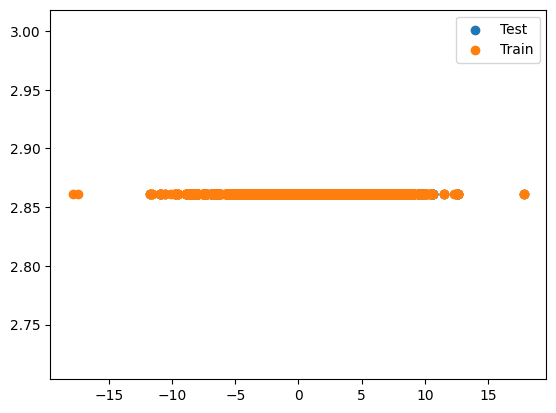

In [ ]:
logp_pred_train = logp_model.predict(x_train_latent)
logp_pred_test = logp_model.predict(x_latent)
plt.scatter(logp, logp_pred_test, label="Test")
plt.scatter(logp_train, logp_pred_train, label="Train")
plt.legend()